In [80]:
################ Library imports ################
import numpy as np
import math as math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import scipy.linalg
import seaborn as sns

import itertools

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

from sklearn.metrics import mean_squared_error, mean_absolute_error

from scipy.optimize import curve_fit
import scipy.optimize as opt

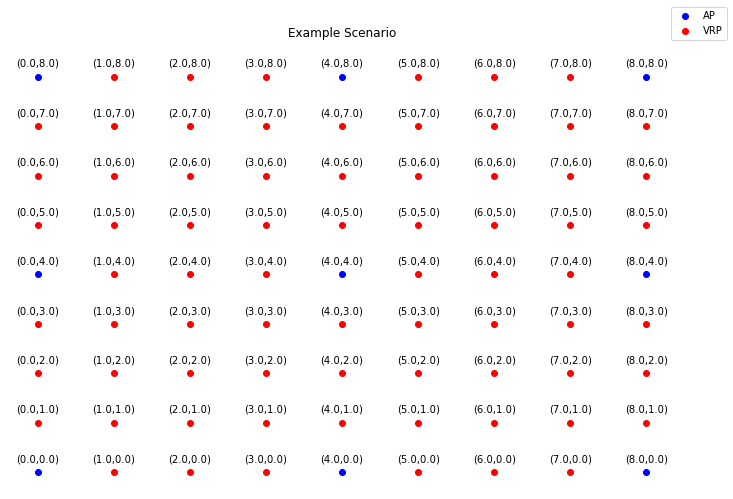

In [3]:
"""
Locations plot
"""
locations = np.array(np.meshgrid(np.linspace(0, 8, 9), np.linspace(0, 8, 9))).T.reshape(-1, 2)

# ----------------------------------------------------------------------
#  AP locations
L_ap = locations[[0,4,8,36,40,44,72,76,80], :]

# ----------------------------------------------------------------------
#  VRP locations
L_vrp = np.delete(locations, [0,4,8,36,40,44,72,76,80], 0)

plt.figure(figsize=(12,8))

plt.scatter(L_ap[:,0], L_ap[:,1], c='b')
plt.scatter(L_vrp[:,0], L_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-5)
plt.title('Example Scenario',pad=20)
plt.axis('off')

for x,y in zip(locations[:,0],locations[:,1]):

    label = f"({x},{y})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

In [4]:
"""
Compute Euclidean distance vector
    
    target --> Reference AP location to calculate distance
    array --> Array of AP/VRP locations
"""
def compute_euclidean_distance_vector(target, array):
    d_vec = np.array([np.linalg.norm(target - i) for (i) in array])
    return d_vec

In [5]:
"""
Polynomial Surface model fitting
    
    loc --> X,Y tuple array of AP locations
    d --> AP RTT distance observations
    order --> Polinomial order
"""
def surface_fit(loc, d, order=1):
    if order == 1:
        A = np.c_[loc[:,0], loc[:,1], np.ones(loc.shape[0])]
        C,_,_,_ = scipy.linalg.lstsq(A, d)
    else:
        A = np.c_[np.ones(loc.shape[0]), loc[:,:2], np.prod(loc[:,:2], axis=1), loc[:,:2]**2]
        C,_,_,_ = scipy.linalg.lstsq(A, d)
    return C

In [6]:
"""
RTT distance estimation
    
    x --> AP's x locations
    y --> AP's y locations
    C --> Model coefficients
"""
def sample_distance(x, y, C):
    
    XX = x.flatten()
    YY = y.flatten()
    
    if C.shape[0] == 3:
        fit = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(x.shape)
    else:
        fit = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(x.shape)
    return fit

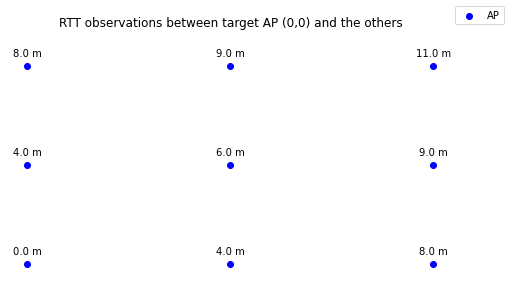

In [7]:
"""
Target AP to compute algorithm: AP[0,0]

Let's assume an euclidean distance as RTT distance observations
""" 
d_RTT = compute_euclidean_distance_vector(L_ap[0], L_ap)

plt.figure(figsize=(8,4))

plt.scatter(L_ap[:,0], L_ap[:,1], c='b')

plt.legend(labels=['AP'],loc="upper right",borderaxespad=-5)
plt.title('RTT observations between target AP (0,0) and the others',pad=30)
plt.axis('off')

for x,y in zip(L_ap[:,0],L_ap[:,1]):
    label = f"{compute_euclidean_distance_vector(L_ap[0], np.array([[x,y]]))[0].round()} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

In [8]:
"""
Surface fitting models
"""

# Plot domain
X,Y = np.meshgrid(np.arange(0.0, 9.0, 1), np.arange(0.0, 9.0, 1))

#Model fitting and surface estimation
model_1 = surface_fit(L_ap, d_RTT)
model_2 = surface_fit(L_ap, d_RTT, 2)

Z_1 = sample_distance(X, Y, model_1)
Z_2 = sample_distance(X, Y, model_2)

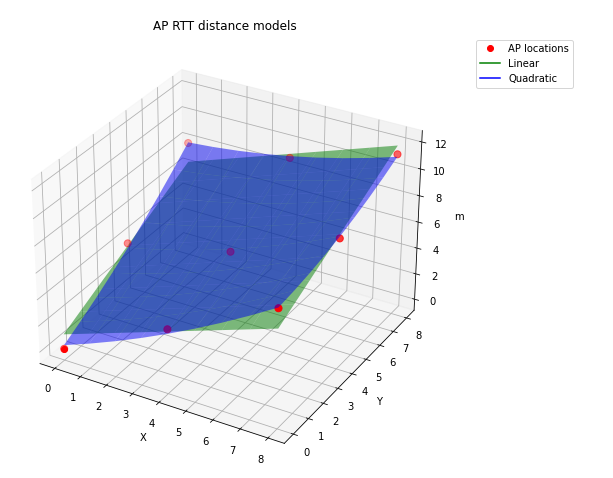

In [9]:
"""
Surface fitting plot
"""
fig = plt.figure(figsize=(12,8))

ax = fig.gca(projection='3d')

l1 = ax.plot_surface(X, Y, Z_1, rstride=1, cstride=1, alpha=0.5, label='linear', color='g')
l2 = ax.plot_surface(X, Y, Z_2, rstride=1, cstride=1, alpha=0.5, label='quadratic', color='b')

ax.scatter(L_ap[:,0], L_ap[:,1], d_RTT, c='r', s=50)

plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('m')
ax.axis('auto')

line_labels = ["AP locations","Linear", "Quadratic"]

ax.plot([0], [0], color="red", marker='o', linewidth=0)[0]
ax.plot([0], [0], color="green")[0]
ax.plot([0], [0], color="blue")[0]

fig.legend(labels=line_labels,loc="upper right",borderaxespad=4)

plt.title('AP RTT distance models')
plt.show()

In [10]:
"""
Mean RTT distance values at VRPs
    _1 --> Order 1 surface fit
    _2 --> Order 2 surface fit
"""

fit_1 = np.reshape(Z_1, (81,1))
fit_2 = np.reshape(Z_2, (81,1))

# ----------------------------------------------------------------------
#  Mean RTT observations between target AP and the rest
m_ap_1 = fit_1[[0,4,8,36,40,44,72,76,80], :]
m_ap_2 = fit_2[[0,4,8,36,40,44,72,76,80], :]

# ----------------------------------------------------------------------
#  Mean RTT observations between target AP and VRPs
m_vrp_1 = np.delete(fit_1, [0,4,8,36,40,44,72,76,80], 0)
m_vrp_2 = np.delete(fit_2, [0,4,8,36,40,44,72,76,80], 0)

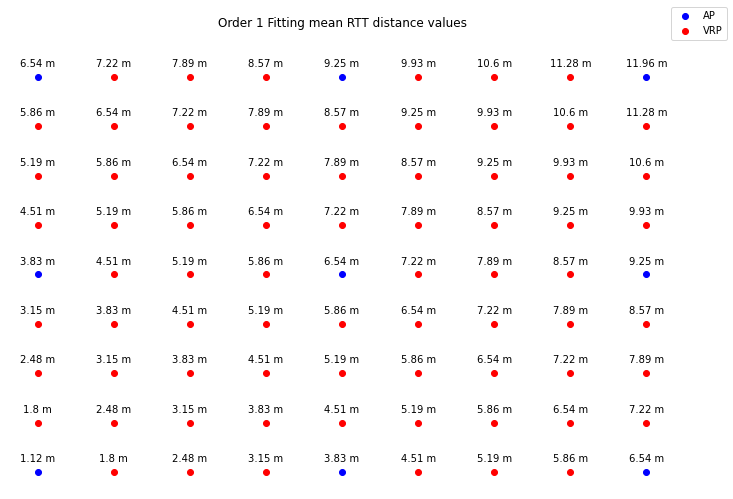

In [11]:
"""
Order 1 RTT Mean distance plot
"""
plt.figure(figsize=(12,8))

plt.scatter(L_ap[:,0], L_ap[:,1], c='b')
plt.scatter(L_vrp[:,0], L_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-5)
plt.title('Order 1 Fitting mean RTT distance values',pad=30)
plt.axis('off')

for x,y in zip(locations[:,0],locations[:,1]):
    label = f"{sample_distance(x, y, model_1).round(2)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

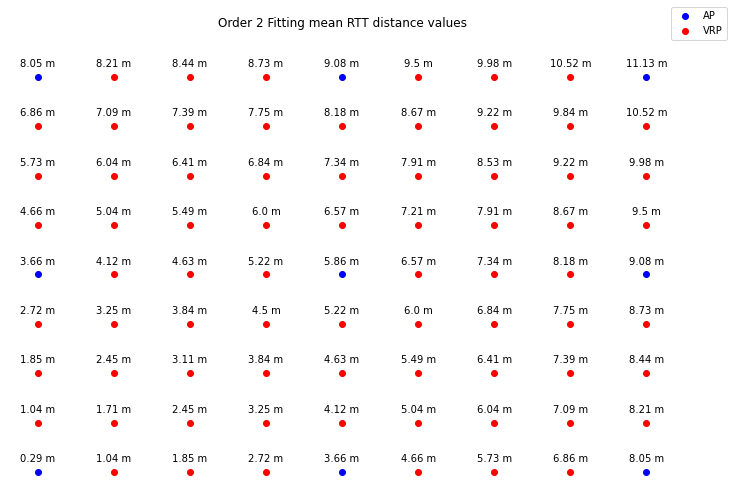

In [12]:
"""
Order 2 RTT distance plot
"""
plt.figure(figsize=(12,8))

plt.scatter(L_ap[:,0], L_ap[:,1], c='b')
plt.scatter(L_vrp[:,0], L_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-5)
plt.title('Order 2 Fitting mean RTT distance values',pad=30)
plt.axis('off')

for x,y in zip(locations[:,0],locations[:,1]):
    label = f"{sample_distance(x, y, model_2).round(2)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

In [13]:
"""
Gaussian Process Kernel definition

Kernel parameters:
    - L --> Length Scale
    - sigma_f --> Constant Kernel Amplitude
"""

def kernel_function(x, y, sigma_f=1, l=1):

    """ Squared Exponential kernel function """
    kernel = sigma_f * np.exp(- (np.linalg.norm(x - y)**2) / (2 * l**2))
    return kernel

In [14]:
def compute_cov_matrices(L_ap, L_vrp, sigma_f=1, l=1):
    """
    Compute components of the covariance matrix of the joint distribution.
    
    We follow the notation:
    
        - K = K(L, L) 
        - K_star = K(L^*, L)
        - K_star2 = K(L^*, L^*)
    """
    n = L_ap.shape[0]
    n_star = L_vrp.shape[0]

    K = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(L_ap, L_ap)]

    K = np.array(K).reshape(n, n)
    
    K_star2 = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(L_vrp, L_vrp)]

    K_star2 = np.array(K_star2).reshape(n_star, n_star)
    
    K_star = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(L_vrp, L_ap)]

    K_star = np.array(K_star).reshape(n_star, n)
    
    return (K, K_star2, K_star)

In [55]:
"""
Computing covariance matrices
"""
l = 0.1
sigma_f = 2

K, K_star2, K_star = compute_cov_matrices(L_ap, L_vrp, sigma_f=sigma_f, l=l)

In [56]:
"""
Gaussian Process Regressor definition

- sigma_n --> Training Noise Variance

Multivariate Joint Distribution: G matrix
"""

n = L_ap.shape[0]
n_star = L_vrp.shape[0]

sigma_n = 0.2

a = np.concatenate((K + (sigma_n**2)*np.eye(n), K_star), axis=0)
print(a.shape)
b = np.concatenate((K_star.T, K_star2), axis=0)
print(b.shape)
G = np.concatenate((a, b), axis=1)
print(G.shape)
G.shape == (n + n_star, n + n_star)

(81, 9)
(81, 72)
(81, 81)


True

[Text(0.5, 1.0, 'Components of the Kernel Covariance Matrix K(L,L)')]

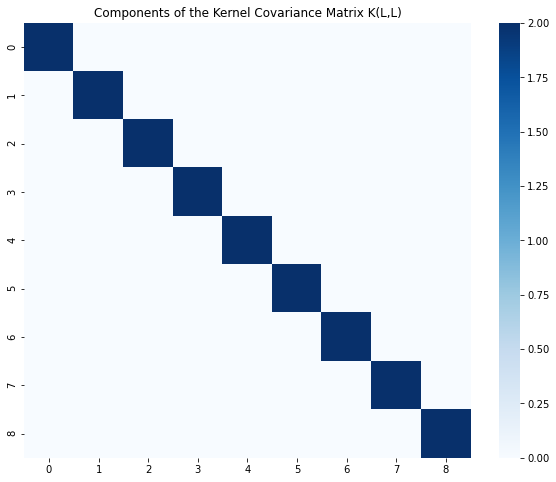

In [57]:
"""
Kernel Covariance Matrix K(L,L)
"""
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=K, cmap='Blues', ax=ax)
ax.set(title='Components of the Kernel Covariance Matrix K(L,L)')

[Text(0.5, 1.0, 'Components of the Kernel Covariance Matrix K(L*,L*)')]

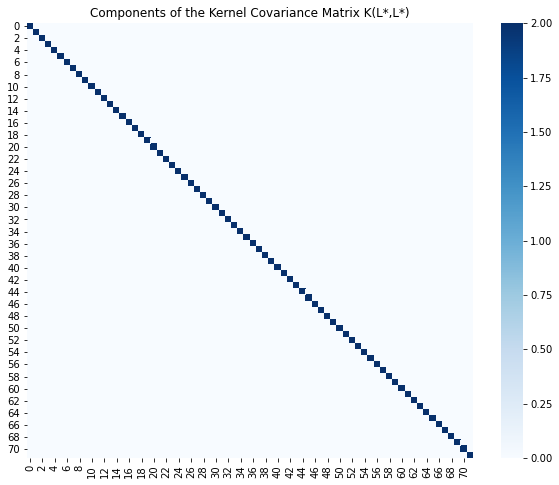

In [58]:
"""
Kernel Covariance Matrix K(L*,L*)
"""
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=K_star2, cmap='Blues', ax=ax)
ax.set(title='Components of the Kernel Covariance Matrix K(L*,L*)')

[Text(0.5, 1.0, 'Components of the Kernel Covariance Matrix K(L*,L)')]

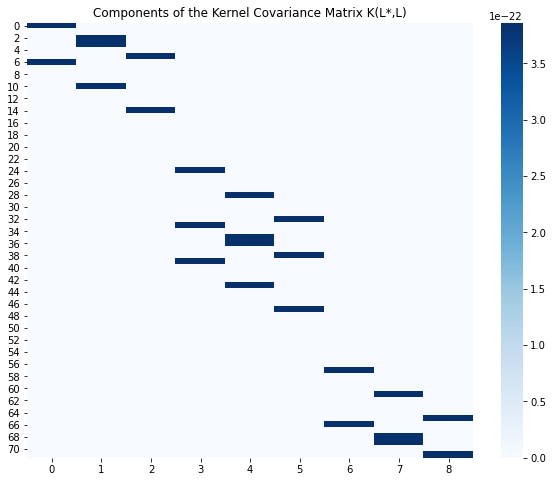

In [59]:
"""
Kernel Covariance Matrix K(L*,L)
"""
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data=K_star, cmap='Blues', ax=ax)
ax.set(title='Components of the Kernel Covariance Matrix K(L*,L)')

In [60]:
def compute_gpr_parameters(m, m_star, d, K, K_star2, K_star, sigma_n):
    
    """Compute gaussian regression parameters."""

    n = K.shape[0]
    n_star = K_star.shape[0]

    # Mean.
    s_bar_star = (m.reshape([n_star, 1]) 
        + np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), d.reshape([n, 1]) - m_star.reshape([n, 1]))))
    # Covariance.
    cov_s_star = K_star2 - np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), K_star.T))
    
    return (s_bar_star.reshape(n_star), cov_s_star)

In [61]:
def zero_mean_gpr(d, K, K_star2, K_star, sigma_n):
    
    """Compute gaussian regression parameters."""

    n = K.shape[0]
    n_star = K_star.shape[0]

    # Mean.
    s_bar_star = np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), d.reshape([n, 1])))
    # Covariance.
    cov_s_star = K_star2 - np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(n)), K_star.T))
    
    return (s_bar_star.reshape(n_star), cov_s_star)

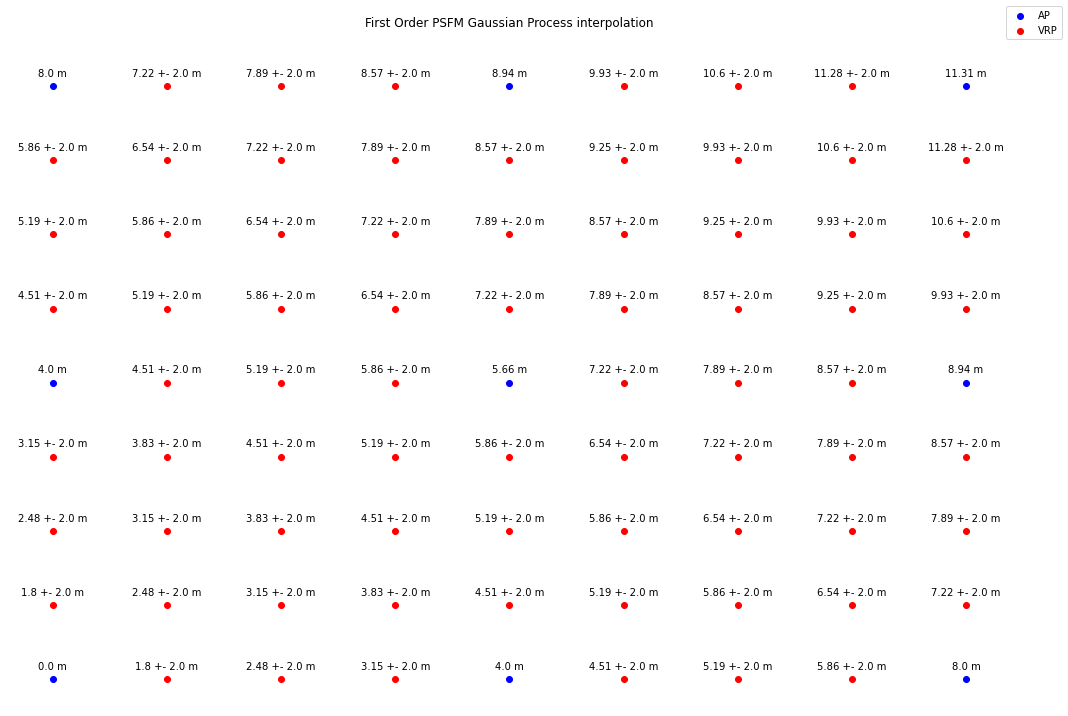

In [62]:
"""
First Order PSFM Gaussian Process interpolation:
    
    s_bar_star --> Mean estimated value for each VRP
    cov_s_star --> Posterior covariance matrix
    var_s_star --> VRP estimation variance
"""

s_bar_star, cov_s_star = compute_gpr_parameters(m_vrp_1, m_ap_1, d_RTT, K, K_star2, K_star, sigma_n)
var_s_star = np.diag(cov_s_star)

plt.figure(figsize=(18,12))

plt.scatter(L_ap[:,0], L_ap[:,1], c='b')
plt.scatter(L_vrp[:,0], L_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-5)
plt.title('First Order PSFM Gaussian Process interpolation',pad=30)
plt.axis('off')

for x in range(len(d_RTT)):
    label = f"{d_RTT[x].round(2)} m"

    plt.annotate(label, # this is the text
                 (L_ap[x,0],L_ap[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x in range(len(s_bar_star)):
    label = f"{s_bar_star[x].round(2)} +- {var_s_star[x].round(2)} m"

    plt.annotate(label, # this is the text
                 (L_vrp[x,0],L_vrp[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

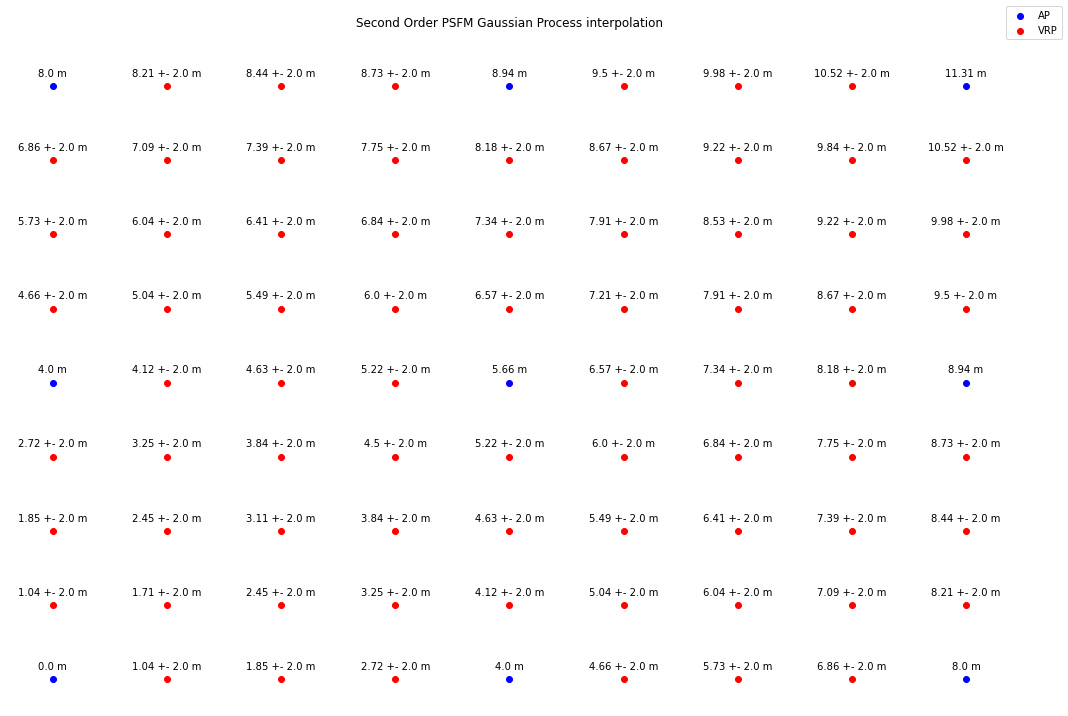

In [63]:
"""
Second Order Gaussian Process interpolation:
    
    s_bar_star --> Mean estimated value for each VRP
    cov_s_star --> Posterior covariance matrix
    var_s_star --> VRP estimation variance
"""

s_bar_star, cov_s_star = compute_gpr_parameters(m_vrp_2, m_ap_2, d_RTT, K, K_star2, K_star, sigma_n)
var_s_star = np.diag(cov_s_star)

plt.figure(figsize=(18,12))

plt.scatter(L_ap[:,0], L_ap[:,1], c='b')
plt.scatter(L_vrp[:,0], L_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-5)
plt.title('Second Order PSFM Gaussian Process interpolation',pad=30)
plt.axis('off')

for x in range(len(d_RTT)):
    label = f"{d_RTT[x].round(2)} m"

    plt.annotate(label, # this is the text
                 (L_ap[x,0],L_ap[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x in range(len(s_bar_star)):
    label = f"{s_bar_star[x].round(2)} +- {var_s_star[x].round(2)} m"

    plt.annotate(label, # this is the text
                 (L_vrp[x,0],L_vrp[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

In [64]:
s_bar_star_2, cov_s_star_2 = zero_mean_gpr(d_RTT, K, K_star2, K_star, sigma_n)
var_s_star_2 = np.diag(cov_s_star_2)

In [65]:
kernel_2 = ConstantKernel(constant_value=sigma_f,constant_value_bounds=(1e-3, 1e3)) \
            * RBF(length_scale=l, length_scale_bounds=(1e-3, 1e3)) 

In [70]:
gp = GaussianProcessRegressor(kernel=kernel_2, alpha=sigma_n**2, n_restarts_optimizer=10)

In [71]:
gp.fit(L_ap, d_RTT)

GaussianProcessRegressor(alpha=0.04000000000000001,
                         kernel=1.41**2 * RBF(length_scale=0.1),
                         n_restarts_optimizer=10)

In [83]:
opt_l = gp.kernel_.get_params().get('k2__length_scale')
opt_sigma_f = gp.kernel_.get_params().get('k1__constant_value')
print(opt_l)
print(opt_sigma_f)
print(gp.kernel_.get_params())

10.36958866724384
96.52242974456327
{'k1': 9.82**2, 'k2': RBF(length_scale=10.4), 'k1__constant_value': 96.52242974456327, 'k1__constant_value_bounds': (0.001, 1000.0), 'k2__length_scale': 10.36958866724384, 'k2__length_scale_bounds': (0.001, 1000.0)}


In [78]:
d_RTT_pred, d_RTT_err = gp.predict(L_vrp, return_cov=True)
print(d_RTT_pred)

[ 0.92277024  1.83541367  2.8248886   4.93840746  6.00677892  7.0430713
  0.92277024  1.60832791  2.3936074   3.26432364  4.20120781  5.1806839
  6.17584883  7.15769961  8.09652944  1.83541367  2.3936074   3.05470726
  3.80873063  4.64017236  5.52848528  6.44891628  7.37365105  8.27319364
  2.8248886   3.26432364  3.80873063  4.45218918  5.18276725  5.98281526
  6.82966437  7.69669119  8.55467915  4.20120781  4.64017236  5.18276725
  6.5378883   7.31471905  8.12535014  4.93840746  5.1806839   5.52848528
  5.98281526  6.5378883   7.18110179  7.89349413  8.65066682  9.42410841
  6.00677892  6.17584883  6.44891628  6.82966437  7.31471905  7.89349413
  8.54855331  9.25647352  9.98915042  7.0430713   7.15769961  7.37365105
  7.69669119  8.12535014  8.65066682  9.25647352  9.92021011 10.61421165
  8.09652944  8.27319364  8.55467915  9.42410841  9.98915042 10.61421165]


In [79]:
def f_opt(x, *args):
    """ Calculates the value of the objective (negative log marginal likelihood) for parameters in *args."""
    X, y, k, x_star = args
    var_f, l, var_n = x
    
    Lxx = np.linalg.cholesky(k(X, X, var_f, l) + var_n*np.eye(X.shape[0]))
    a = np.linalg.solve(Lxx.T, np.linalg.solve(Lxx, y))
    
#     return -(- 0.5 * y.T @ a - np.log(np.trace(Lxx)) - X.shape[0]*np.log(2 * math.pi)/2)
    return -(- 0.5 * y.T @ a - 0.5*np.trace(np.log(Lxx)) - X.shape[0]*np.log(2 * math.pi)/2)

In [87]:
bounds = [[0, np.inf], [0, np.inf], [0.0001, np.inf]]  # bound the hyper-parameters to always be positive
args = (L_ap, d_RTT, kernel_function, L_vrp)  # arguments used in objective function
x0 = [3, 3, 0.1]  # initial guess at parameters being optimised [s_f, l, s_n]
res = opt.fmin_l_bfgs_b(f_opt, x0, args=args, approx_grad=True, bounds=bounds)  # call the optimisation algorithm

<ipython-input-79-b8b216956e66>:10: RuntimeWarning: divide by zero encountered in log
  return -(- 0.5 * y.T @ a - 0.5*np.trace(np.log(Lxx)) - X.shape[0]*np.log(2 * math.pi)/2)


In [88]:
var_f = res[0][0] # signal variance
l = res[0][1]  # lengthscale
var_n = res[0][2]  # noise variance

print("Signal variance: %.6f\nLengthscale: %.6f\nNoise variance: %.6f" % (var_f, l, var_n))

Signal variance: 82.766224
Lengthscale: 3.000000
Noise variance: 23.765211
